In [1]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from torchvision.datasets import FashionMNIST
from torchvision import transforms

fashion_mnist_train = FashionMNIST("./data/FashionMNIST", train=True,
                                   download=True, transform=transforms.ToTensor())
fashion_mnist_test = FashionMNIST("./data/FashionMNIST", train=False,
                                   download=True, transform=transforms.ToTensor())

batch_size = 128
train_loader = DataLoader(fashion_mnist_train, batch_size=batch_size,
                          shuffle=True, num_workers=14)
test_loader = DataLoader(fashion_mnist_test, batch_size=batch_size,
                         shuffle=True, num_workers=14)

In [5]:
class FlattenLayer(nn.Module):
    def forward(self, x):
        return torch.flatten(x, start_dim=1)

conv_net = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.Dropout2d(0.25),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Dropout2d(0.25),
    FlattenLayer()
)

test_input = torch.ones(1, 1, 28, 28)
conv_output_size = conv_net(test_input).size()[-1]

mlp = nn.Sequential(
    nn.Linear(conv_output_size, 200),
    nn.ReLU(),
    nn.BatchNorm1d(200),
    nn.Dropout(0.25),
    nn.Linear(200, 10)
)

net = nn.Sequential(
    conv_net,
    mlp
)
'''
net = nn.Sequential(
    FlattenLayer(),
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.BatchNorm1d(200),
    nn.Dropout(0.25),
    nn.Linear(200, 200),
    nn.ReLU(),
    nn.BatchNorm1d(200),
    nn.Dropout(0.25),
    nn.Linear(200, 200),
    nn.ReLU(),
    nn.BatchNorm1d(200),
    nn.Dropout(0.25),
    nn.Linear(200, 10)
)
'''

'\nnet = nn.Sequential(\n    FlattenLayer(),\n    nn.Linear(784, 200),\n    nn.ReLU(),\n    nn.BatchNorm1d(200),\n    nn.Dropout(0.25),\n    nn.Linear(200, 200),\n    nn.ReLU(),\n    nn.BatchNorm1d(200),\n    nn.Dropout(0.25),\n    nn.Linear(200, 200),\n    nn.ReLU(),\n    nn.BatchNorm1d(200),\n    nn.Dropout(0.25),\n    nn.Linear(200, 10)\n)\n'

In [6]:
def eval_net(net, data_loader, device="cpu"):
    net.eval()
    ys = []
    ypreds = []
    for x, y in data_loader:
        x = x.to(device)
        y = y.to(device)
        with torch.no_grad():
            _, y_pred = net(x).max(1)
        ys.append(y)
        ypreds.append(y_pred)
    ys = torch.cat(ys)
    ypreds = torch.cat(ypreds)
    acc = (ys == ypreds).float().sum() / len(ys)
    return acc.item()

train_losses = []
train_acc = []
val_acc = []

def train_net(net, train_loader, test_loader, optimizer_cls=optim.Adam,
              loss_fn=nn.CrossEntropyLoss(), n_iter=10, device="cpu"):
    optimizer = optimizer_cls(net.parameters())
    for epoc in range(n_iter):
        running_loss = 0.0
        net.train()
        n = 0
        n_acc = 0
        for i, (xx, yy) in tqdm.tqdm(enumerate(train_loader),
                                     total = len(train_loader)):
            xx = xx.to(device)
            yy = yy.to(device)
            h = net(xx)
            loss = loss_fn(h, yy)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            n += len(xx)
            y_pred = h.argmax(1)
            n_acc += (y_pred == yy).float().sum().item()
        train_losses.append(running_loss / i)
        train_acc.append(n_acc / n)
        val_acc.append(eval_net(net, test_loader, device))
        print("epoc: {}\ttrain_loss: {:.3f}\ttrain_acc: {:.3f}\tval_acc: {:.3f}".format(
             epoc, train_losses[-1], train_acc[-1], val_acc[-1]), flush=True)

In [7]:
net.to("cuda:0")
train_net(net, train_loader, test_loader, n_iter=20, device="cuda:0")

100%|██████████| 469/469 [00:01<00:00, 272.23it/s]


epoc: 0	train_loss: 0.468	train_acc: 0.835	val_acc: 0.883


100%|██████████| 469/469 [00:01<00:00, 268.94it/s]


epoc: 1	train_loss: 0.322	train_acc: 0.882	val_acc: 0.893


100%|██████████| 469/469 [00:01<00:00, 269.33it/s]


epoc: 2	train_loss: 0.287	train_acc: 0.894	val_acc: 0.904


100%|██████████| 469/469 [00:01<00:00, 271.48it/s]


epoc: 3	train_loss: 0.262	train_acc: 0.903	val_acc: 0.902


100%|██████████| 469/469 [00:01<00:00, 273.53it/s]


epoc: 4	train_loss: 0.246	train_acc: 0.909	val_acc: 0.901


100%|██████████| 469/469 [00:01<00:00, 271.07it/s]


epoc: 5	train_loss: 0.233	train_acc: 0.914	val_acc: 0.902


100%|██████████| 469/469 [00:01<00:00, 286.36it/s]


epoc: 6	train_loss: 0.224	train_acc: 0.917	val_acc: 0.910


100%|██████████| 469/469 [00:01<00:00, 268.06it/s]


epoc: 7	train_loss: 0.214	train_acc: 0.920	val_acc: 0.913


100%|██████████| 469/469 [00:01<00:00, 268.77it/s]


epoc: 8	train_loss: 0.207	train_acc: 0.923	val_acc: 0.907


100%|██████████| 469/469 [00:01<00:00, 276.02it/s]


epoc: 9	train_loss: 0.200	train_acc: 0.925	val_acc: 0.913


100%|██████████| 469/469 [00:01<00:00, 271.19it/s]


epoc: 10	train_loss: 0.195	train_acc: 0.926	val_acc: 0.916


100%|██████████| 469/469 [00:01<00:00, 273.67it/s]


epoc: 11	train_loss: 0.186	train_acc: 0.930	val_acc: 0.914


100%|██████████| 469/469 [00:01<00:00, 280.57it/s]


epoc: 12	train_loss: 0.183	train_acc: 0.931	val_acc: 0.915


100%|██████████| 469/469 [00:01<00:00, 272.06it/s]


epoc: 13	train_loss: 0.175	train_acc: 0.934	val_acc: 0.917


100%|██████████| 469/469 [00:01<00:00, 277.49it/s]


epoc: 14	train_loss: 0.174	train_acc: 0.936	val_acc: 0.919


100%|██████████| 469/469 [00:01<00:00, 272.57it/s]


epoc: 15	train_loss: 0.168	train_acc: 0.936	val_acc: 0.919


100%|██████████| 469/469 [00:01<00:00, 268.95it/s]


epoc: 16	train_loss: 0.164	train_acc: 0.939	val_acc: 0.920


100%|██████████| 469/469 [00:01<00:00, 271.35it/s]


epoc: 17	train_loss: 0.159	train_acc: 0.940	val_acc: 0.921


100%|██████████| 469/469 [00:01<00:00, 273.78it/s]


epoc: 18	train_loss: 0.159	train_acc: 0.940	val_acc: 0.919


100%|██████████| 469/469 [00:01<00:00, 268.61it/s]


epoc: 19	train_loss: 0.152	train_acc: 0.943	val_acc: 0.918


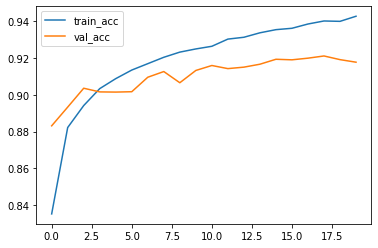

In [8]:
plt.plot(train_acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend()

In [2]:
from torchvision.datasets import ImageFolder
from torchvision import transforms

train_imgs = ImageFolder(
    "./data/taco_and_burrito/train/",
    transform=transforms.Compose([transforms.RandomCrop(224), transforms.ToTensor()])
)
test_imgs = ImageFolder(
    "./data/taco_and_burrito/test/",
    transform=transforms.Compose([transforms.CenterCrop(224), transforms.ToTensor()])
)

train_loader = DataLoader(train_imgs, batch_size=32,
                          shuffle=True, num_workers=14)
test_loader = DataLoader(test_imgs, batch_size=32,
                         shuffle=True, num_workers=14)

print(train_imgs.classes)
print(train_imgs.class_to_idx)
print(train_imgs)

['burrito', 'taco']
{'burrito': 0, 'taco': 1}
Dataset ImageFolder
    Number of datapoints: 712
    Root Location: ./data/taco_and_burrito/train/
    Transforms (if any): Compose(
                             RandomCrop(size=(224, 224), padding=0)
                             ToTensor()
                         )
    Target Transforms (if any): None


In [3]:
from torchvision.models import resnet18

net = resnet18(pretrained=True)

for p in net.parameters():
    p.requires_grad=False
    
fc_input_dim = net.fc.in_features
net.fc = nn.Linear(fc_input_dim, 2)

In [4]:
def eval_net(net, data_loader, device="cpu"):
    net.eval()
    ys = []
    ypreds = []
    for x, y in data_loader:
        x = x.to(device)
        y = y.to(device)
        with torch.no_grad():
            y_pred = net(x).argmax(1)
        ys.append(y)
        ypreds.append(y_pred)
    ys = torch.cat(ys)
    ypreds = torch.cat(ypreds)
    acc = (ys == ypreds).float().sum() / len(ys)
    return acc.item()

train_losses = []
train_acc = []
val_acc = []

def train_net(net, train_loader, test_loader, only_fc=True,
              optimizer_cls=optim.Adam, loss_fn=nn.CrossEntropyLoss(),
              n_iter=10, device="cpu"):
    if only_fc:
        optimizer = optimizer_cls(net.fc.parameters())
    else:
        optimizer = optimizer_cls(net.parameters())
    for epoc in range(n_iter):
        running_loss = 0.0
        net.train()
        n = 0
        n_acc = 0
        for i, (xx, yy) in tqdm.tqdm(enumerate(train_loader),
                                     total = len(train_loader)):
            xx = xx.to(device)
            yy = yy.to(device)
            h = net(xx)
            loss = loss_fn(h, yy)
            optimizer.zero_grad()
            running_loss += loss
            loss.backward()
            optimizer.step()
            n += len(xx)
            y_pred = h.argmax(1)
            n_acc += (yy == y_pred).float().sum().item()
        train_losses.append(running_loss / i)
        train_acc.append(n_acc / n)
        val_acc.append(eval_net(net, test_loader, device))
        print("epoc: {}\ttrain_loss: {:.3f}\ttrain_acc: {:.3f}\tval_acc: {:.3f}".format(
             epoc, train_losses[-1], train_acc[-1], val_acc[-1]), flush=True)

In [5]:
net.to("cuda:0")
train_net(net, train_loader, test_loader, n_iter=20, device="cuda:0")

100%|██████████| 23/23 [00:00<00:00, 25.26it/s]


epoc: 0	train_loss: 0.676	train_acc: 0.610	val_acc: 0.750


100%|██████████| 23/23 [00:00<00:00, 27.60it/s]


epoc: 1	train_loss: 0.536	train_acc: 0.779	val_acc: 0.833


100%|██████████| 23/23 [00:00<00:00, 27.34it/s]


epoc: 2	train_loss: 0.444	train_acc: 0.815	val_acc: 0.817


100%|██████████| 23/23 [00:00<00:00, 28.33it/s]


epoc: 3	train_loss: 0.424	train_acc: 0.833	val_acc: 0.850


100%|██████████| 23/23 [00:00<00:00, 26.69it/s]


epoc: 4	train_loss: 0.428	train_acc: 0.826	val_acc: 0.850


100%|██████████| 23/23 [00:00<00:00, 27.44it/s]


epoc: 5	train_loss: 0.381	train_acc: 0.854	val_acc: 0.800


100%|██████████| 23/23 [00:00<00:00, 27.23it/s]


epoc: 6	train_loss: 0.349	train_acc: 0.860	val_acc: 0.883


100%|██████████| 23/23 [00:00<00:00, 28.11it/s]


epoc: 7	train_loss: 0.403	train_acc: 0.837	val_acc: 0.833


100%|██████████| 23/23 [00:00<00:00, 27.58it/s]


epoc: 8	train_loss: 0.341	train_acc: 0.865	val_acc: 0.850


100%|██████████| 23/23 [00:00<00:00, 27.74it/s]


epoc: 9	train_loss: 0.345	train_acc: 0.872	val_acc: 0.883


100%|██████████| 23/23 [00:00<00:00, 27.53it/s]


epoc: 10	train_loss: 0.316	train_acc: 0.872	val_acc: 0.850


100%|██████████| 23/23 [00:00<00:00, 27.56it/s]


epoc: 11	train_loss: 0.316	train_acc: 0.867	val_acc: 0.783


100%|██████████| 23/23 [00:00<00:00, 28.26it/s]


epoc: 12	train_loss: 0.339	train_acc: 0.865	val_acc: 0.817


100%|██████████| 23/23 [00:00<00:00, 28.65it/s]


epoc: 13	train_loss: 0.306	train_acc: 0.883	val_acc: 0.883


100%|██████████| 23/23 [00:00<00:00, 27.73it/s]


epoc: 14	train_loss: 0.301	train_acc: 0.871	val_acc: 0.900


100%|██████████| 23/23 [00:00<00:00, 27.69it/s]


epoc: 15	train_loss: 0.312	train_acc: 0.881	val_acc: 0.867


100%|██████████| 23/23 [00:00<00:00, 27.89it/s]


epoc: 16	train_loss: 0.362	train_acc: 0.871	val_acc: 0.883


100%|██████████| 23/23 [00:00<00:00, 27.83it/s]


epoc: 17	train_loss: 0.320	train_acc: 0.868	val_acc: 0.883


100%|██████████| 23/23 [00:00<00:00, 27.49it/s]


epoc: 18	train_loss: 0.297	train_acc: 0.869	val_acc: 0.900


100%|██████████| 23/23 [00:00<00:00, 27.36it/s]


epoc: 19	train_loss: 0.269	train_acc: 0.895	val_acc: 0.867


In [8]:
params = net.state_dict()
torch.save(params, "./data/taco_burito.prm", pickle_protocol=4)

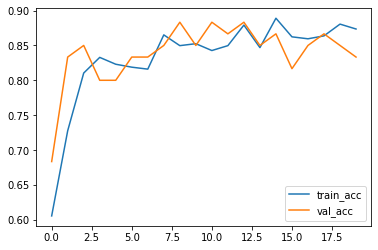

In [13]:
plt.plot(train_acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend()

In [14]:
conv_net = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.BatchNorm2d(128),
    FlattenLayer()
)

test_input = torch.ones(1, 3, 224, 224)
conv_output_size = conv_net(test_input).size()[-1]

net = nn.Sequential(
    conv_net,
    nn.Linear(conv_output_size, 2)
)
net.to("cuda:0")

train_losses = []
train_acc = []
val_acc = []

train_net(net, train_loader, test_loader, n_iter=20, only_fc=False, device="cuda:0")

100%|██████████| 23/23 [00:01<00:00, 15.91it/s]


epoc: 0	train_loss: 2.669	train_acc: 0.574	val_acc: 0.567


100%|██████████| 23/23 [00:01<00:00, 15.91it/s]


epoc: 1	train_loss: 3.220	train_acc: 0.576	val_acc: 0.633


100%|██████████| 23/23 [00:01<00:00, 16.32it/s]


epoc: 2	train_loss: 2.314	train_acc: 0.645	val_acc: 0.667


100%|██████████| 23/23 [00:01<00:00, 16.14it/s]


epoc: 3	train_loss: 2.344	train_acc: 0.629	val_acc: 0.617


100%|██████████| 23/23 [00:01<00:00, 16.36it/s]


epoc: 4	train_loss: 2.330	train_acc: 0.621	val_acc: 0.517


100%|██████████| 23/23 [00:01<00:00, 16.46it/s]


epoc: 5	train_loss: 2.675	train_acc: 0.650	val_acc: 0.567


100%|██████████| 23/23 [00:01<00:00, 15.89it/s]


epoc: 6	train_loss: 2.821	train_acc: 0.636	val_acc: 0.567


100%|██████████| 23/23 [00:01<00:00, 16.24it/s]


epoc: 7	train_loss: 2.350	train_acc: 0.642	val_acc: 0.600


100%|██████████| 23/23 [00:01<00:00, 15.64it/s]


epoc: 8	train_loss: 2.179	train_acc: 0.643	val_acc: 0.550


100%|██████████| 23/23 [00:01<00:00, 15.95it/s]


epoc: 9	train_loss: 1.963	train_acc: 0.667	val_acc: 0.667


100%|██████████| 23/23 [00:01<00:00, 15.64it/s]


epoc: 10	train_loss: 2.077	train_acc: 0.692	val_acc: 0.500


100%|██████████| 23/23 [00:01<00:00, 16.11it/s]


epoc: 11	train_loss: 1.872	train_acc: 0.656	val_acc: 0.633


100%|██████████| 23/23 [00:01<00:00, 15.78it/s]


epoc: 12	train_loss: 1.670	train_acc: 0.687	val_acc: 0.717


100%|██████████| 23/23 [00:01<00:00, 15.96it/s]


epoc: 13	train_loss: 2.093	train_acc: 0.684	val_acc: 0.533


100%|██████████| 23/23 [00:01<00:00, 15.25it/s]


epoc: 14	train_loss: 1.954	train_acc: 0.691	val_acc: 0.733


100%|██████████| 23/23 [00:01<00:00, 16.10it/s]


epoc: 15	train_loss: 1.858	train_acc: 0.715	val_acc: 0.550


100%|██████████| 23/23 [00:01<00:00, 16.37it/s]


epoc: 16	train_loss: 1.928	train_acc: 0.688	val_acc: 0.683


100%|██████████| 23/23 [00:01<00:00, 16.19it/s]


epoc: 17	train_loss: 1.456	train_acc: 0.723	val_acc: 0.600


100%|██████████| 23/23 [00:01<00:00, 15.83it/s]


epoc: 18	train_loss: 1.533	train_acc: 0.725	val_acc: 0.617


100%|██████████| 23/23 [00:01<00:00, 16.62it/s]


epoc: 19	train_loss: 1.475	train_acc: 0.697	val_acc: 0.633


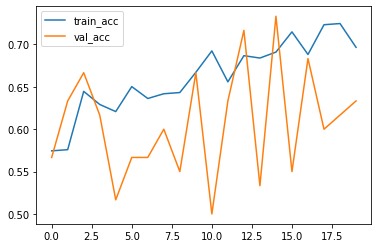

In [15]:
plt.plot(train_acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend()

In [16]:
class DownSizedPairImageFolder(ImageFolder):
    def __init__(self, root, transform=None, large_size=128, small_size=32, **kwds):
        super().__init__(root, transform=transform, **kwds)
        self.large_resizer = transforms.Resize(large_size)
        self.small_resizer = transforms.Resize(small_size)
        
    def __getitem__(self, index):
        path, _ = self.imgs[index]
        img = self.loader(path)
        large_img = self.large_resizer(img)
        small_img = self.small_resizer(img)
        
        if self.transform is not None:
            large_img = self.transform(large_img)
            small_img = self.transform(small_img)
            
        return small_img, large_img

In [17]:
train_data = DownSizedPairImageFolder("./data/lfw-deepfunneled/train",
                                      transform=transforms.ToTensor())
test_data = DownSizedPairImageFolder("./data/lfw-deepfunneled/test",
                                     transform=transforms.ToTensor())
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size,
                          shuffle=True, num_workers=14)
test_loader = DataLoader(test_data, batch_size=batch_size,
                         shuffle=True, num_workers=14)

In [18]:
net = nn.Sequential(
    nn.Conv2d(3, 256, 4, stride=2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(256),
    nn.Conv2d(256, 512, 4, stride=2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(512),
    nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(256),
    nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(128),
    nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1)
)

test_input = torch.ones(1, 3, 32, 32)
test_output_size = net(test_input).size()
print(test_output_size)

torch.Size([1, 3, 128, 128])


In [19]:
import math
def psnr(mse, max_v=1.0):
    return 10 * math.log10(max_v**2 / mse)

def eval_net(net, data_loader, device="cpu"):
    net.eval()
    ys = []
    ypreds = []
    for x, y in data_loader:
        x = x.to(device)
        y = y.to(device)
        with torch.no_grad():
            y_pred = net(x)
        ys.append(y)
        ypreds.append(y_pred)
    ys = torch.cat(ys)
    ypreds = torch.cat(ypreds)
    loss = nn.functional.mse_loss(ypreds, ys).item()
    score = psnr(loss)
    return score

train_losses = []
train_acc = []
val_acc = []

def train_net(net, train_loader, test_loader, n_iter=10, device="cpu",
              optimizer_cls=optim.Adam, loss_fn=nn.MSELoss()):
    optimizer = optimizer_cls(net.parameters())
    for epoc in range(n_iter):
        running_loss = 0.0
        net.train()
        n = 0
        score = 0
        for i, (xx, yy) in tqdm.tqdm(enumerate(train_loader), total=len(train_loader)):
            xx = xx.to(device)
            yy = yy.to(device)
            y_pred = net(xx)
            loss = loss_fn(y_pred, yy)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            n += len(xx)
        train_losses.append(running_loss / len(train_loader))
        train_acc.append(psnr(train_losses[-1]))
        val_acc.append(eval_net(net, test_loader, device))
        print("epoc: {}\ttrain_losses: {:.5f}\ttrain_acc: {:.3f}\tval_acc: {:.3f}".format(
            epoc, train_losses[-1], train_acc[-1], val_acc[-1]), flush=True)

In [20]:
net.to("cuda:0")
train_net(net, train_loader, test_loader, device="cuda:0")

100%|██████████| 409/409 [00:14<00:00, 27.56it/s]


epoc: 0	train_losses: 0.01616	train_acc: 17.915	val_acc: 24.888


100%|██████████| 409/409 [00:14<00:00, 27.71it/s]


epoc: 1	train_losses: 0.00313	train_acc: 25.046	val_acc: 25.573


100%|██████████| 409/409 [00:14<00:00, 27.53it/s]


epoc: 2	train_losses: 0.00289	train_acc: 25.386	val_acc: 26.663


100%|██████████| 409/409 [00:14<00:00, 27.81it/s]


epoc: 3	train_losses: 0.00253	train_acc: 25.976	val_acc: 26.701


100%|██████████| 409/409 [00:14<00:00, 27.84it/s]


epoc: 4	train_losses: 0.00243	train_acc: 26.149	val_acc: 27.191


100%|██████████| 409/409 [00:14<00:00, 27.68it/s]


epoc: 5	train_losses: 0.00237	train_acc: 26.254	val_acc: 26.697


100%|██████████| 409/409 [00:15<00:00, 26.56it/s]


epoc: 6	train_losses: 0.00243	train_acc: 26.141	val_acc: 26.229


100%|██████████| 409/409 [00:15<00:00, 26.41it/s]


epoc: 7	train_losses: 0.00224	train_acc: 26.491	val_acc: 27.295


100%|██████████| 409/409 [00:15<00:00, 26.51it/s]


epoc: 8	train_losses: 0.00224	train_acc: 26.495	val_acc: 27.015


100%|██████████| 409/409 [00:15<00:00, 26.41it/s]


epoc: 9	train_losses: 0.00221	train_acc: 26.564	val_acc: 27.521


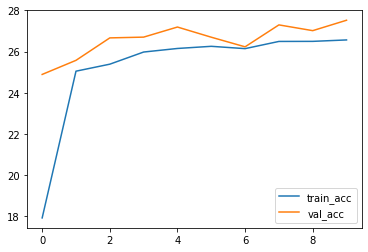

In [21]:
plt.plot(train_acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend()

In [22]:
from torchvision.utils import save_image

random_test_loader = DataLoader(test_data, batch_size=4, shuffle=True)
it = iter(random_test_loader)
x, y = next(it)

bl_recon = torch.nn.functional.upsample(x, 128, mode="bilinear", align_corners=True)
yp = net(x.to("cuda:0")).to("cpu")

save_image(torch.cat([y, bl_recon, yp], 0), "cnn_upscale.jpg", nrow=4)

/home/yochimonji/miniconda3/envs/pytorch_v04/lib/python3.6/site-packages/torch/nn/functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [1]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import tqdm
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.utils import save_image
%matplotlib inline

In [2]:
img_data = ImageFolder("./data/102flowers/", transform=transforms.Compose(
    [transforms.Resize(80), transforms.CenterCrop(64), transforms.ToTensor()]))

batch_size = 64
img_loader = DataLoader(img_data, batch_size=batch_size,
                        shuffle=True, num_workers=8)
print(img_data)
print(img_loader)

Dataset ImageFolder
    Number of datapoints: 8189
    Root Location: ./data/102flowers/
    Transforms (if any): Compose(
                             Resize(size=80, interpolation=PIL.Image.BILINEAR)
                             CenterCrop(size=(64, 64))
                             ToTensor()
                         )
    Target Transforms (if any): None


In [3]:
nz = 100
ngf = 32

class GNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )
        
    def forward(self, x):
        out = self.main(x)
        return out

In [4]:
ndf = 32

class DNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False)
        )
        
    def forward(self, x):
        out = self.main(x)
        return out.squeeze()

In [5]:
d = DNet().to("cuda")
g = GNet().to("cuda")

opt_d = optim.Adam(d.parameters(), lr=0.0002, betas=(0.5, 0.999))
opt_g = optim.Adam(g.parameters(), lr=0.0002, betas=(0.5, 0.999))

ones = torch.ones(batch_size).to("cuda")
zeros = torch.zeros(batch_size).to("cuda")
loss_f = nn.BCEWithLogitsLoss()

fixed_z = torch.randn(batch_size, nz, 1, 1).to("cuda")

In [6]:
from statistics import mean

def train_dcgan(g, d, opt_g, opt_d, loader):
    log_loss_g = []
    log_loss_d = []
    for real_img, _ in tqdm.tqdm(loader):
        batch_len = len(real_img)
        real_img = real_img.to("cuda")
        
        z = torch.randn(batch_len, nz, 1, 1).to("cuda")
        fake_img = g(z)
        fake_img_tensor = fake_img.detach()
        
        out = d(fake_img)
        loss_g = loss_f(out, ones[: batch_len])
        log_loss_g.append(loss_g.item())
        
        d.zero_grad()
        g.zero_grad()
        loss_g.backward()
        opt_g.step()
        
        real_out = d(real_img)
        loss_d_real = loss_f(real_out, ones[: batch_len])
        
        fake_img = fake_img_tensor.to("cuda")
        fake_out = d(fake_img)
        loss_d_fake = loss_f(fake_out, zeros[: batch_len])
        
        loss_d = loss_d_real + loss_d_fake
        log_loss_d.append(loss_d.item())
        
        d.zero_grad()
        g.zero_grad()
        loss_d.backward()
        opt_d.step()
        
    return mean(log_loss_g), mean(log_loss_d)

In [7]:
for epoch in range(301):
    train_dcgan(g, d, opt_g, opt_d, img_loader)
    if epoch % 10 == 0:
        torch.save(g.state_dict(), "./params/g_{:03d}.prm".format(epoch),
                   pickle_protocol=4)
        torch.save(g.state_dict(), "./params/d_{:03d}.prm".format(epoch),
                   pickle_protocol=4)
        generated_img = g(fixed_z)
        save_image(generated_img, "./dcgan_img/{:03d}.jpg".format(epoch))

100%|██████████| 128/128 [00:05<00:00, 23.43it/s]
